In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
import os


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the Keystroke Logging dataset
Let's have a look at all the data files

In [2]:
DATA_DIR = '/kaggle/input/linking-writing-processes-to-writing-quality/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv
/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv


## Data dictionary

Let's dicover the data which are composed of :
- events
- activities
- scores

**Events**

| Column             | Definition                                                                |
| ------------------ | ------------------------------------------------------------------------- |
| essay_id_comp      | The unique ID of the essay                                                |
| event_id           | The index of the event, ordered chronologically                           |
| down_time          | The time of the down event in milliseconds                                |
| up_time            | The time of the up event in milliseconds                                  |
| action_time        | The duration of the event (the difference between down_time and up_time)  |
| activity           | The category of activity which the event belongs to                       |
| down_event         | The name of the event when the key/mouse is pressed                       |
| up_event           | The name of the event when the key/mouse is released                      |
| text_change        | The text that changed as a result of the event (if any)                   |
| cursor_position    | The character index of the text cursor after the event                    |
| word_count         | The word count of the essay after the event                               |

**Activities**

| Activity Name                  | Definition                                                                                 |
| ------------------------------ | ------------------------------------------------------------------------------------------ |
| Nonproduction                  | The event does not alter the text in any way                                               |
| Input                          | The event adds text to the essay                                                           |
| Remove/Cut                     | The event removes text from the essay                                                      |
| Paste                          | The event changes the text through a paste input                                           |
| Replace                        | The event replaces a section of text with another string                                   |
| Move From [x1, y1] To [x2, y2] | The event moves a section of text spanning character index x1, y1 to a new location x2, y2 |

**Scores**

| Column         | Definition                                                                        |
| -------------- | --------------------------------------------------------------------------------- |
| essay_id_comp  | The unique ID of the essay                                                        |
| score          | The score the essay received out of 6 (the prediction target for the competition) |
| split          | The train-test split of the essay                                                 |

# Explore the dataset

Let's look at the distribution of labels in the training set.

In [3]:
df_train_scores = pd.read_csv(DATA_DIR + "train_scores.csv")
df_train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


Text(0.5, 1.0, 'Distribution of scores')

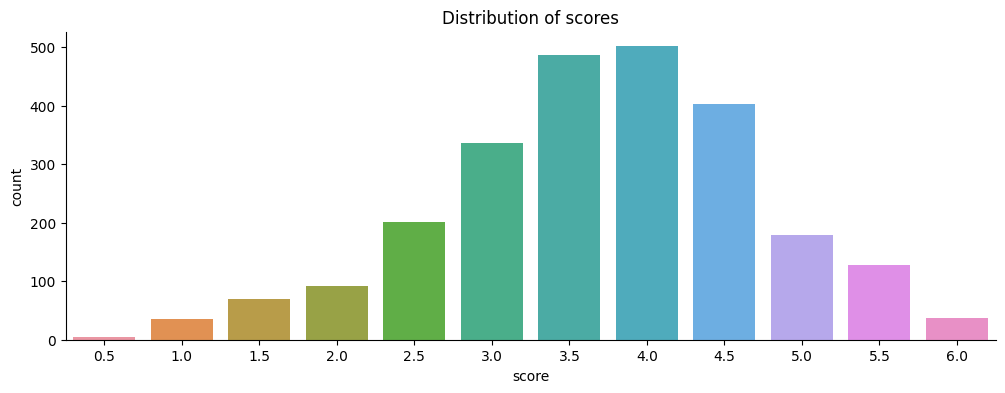

In [4]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_scores,
                   x="score")

ax.set_title("Distribution of scores")

# Event

In [5]:
df_train_logs = pd.read_csv(DATA_DIR + "train_logs.csv")
df_test_logs = pd.read_csv(DATA_DIR + "test_logs.csv")


print(df_train_logs.shape)
print(df_test_logs.shape)
df_train_logs.head()

(8405898, 11)
(6, 11)


,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [6]:
def calculate_production_rate(dataframe):
    # Convert 'action_time' column to datetime
    dataframe['action_time'] = pd.to_datetime(dataframe['action_time'])

    # Calculate total characters written during the process
    dataframe['chars_written'] = dataframe['text_change'].str.len()

    # Calculate total time taken during the process (in minutes) for each essay_id
    essay_times = dataframe.groupby('id')['action_time']
    start_time = essay_times.min()
    end_time = essay_times.max()
    total_time_taken = (end_time - start_time).dt.total_seconds() / 60

    # Calculate total characters written during the process for each essay_id
    total_chars_written = dataframe.groupby('id')['chars_written'].sum()

    # Calculate production rate during the process (characters per minute) for each essay_id
    production_rate_process = total_chars_written / total_time_taken

    # Calculate total characters in the final product for each essay_id
    final_chars = dataframe.groupby(['id', 'event_id'])['text_change'].last().str.len()
    total_final_chars = final_chars.groupby('id').sum()

    # Calculate time taken for the final product for each essay_id (in minutes)
    essay_times_final = dataframe.groupby(['id', 'event_id'])['action_time']
    final_start_time = essay_times_final.min()
    final_end_time = essay_times_final.max()
    final_time_taken = (final_end_time - final_start_time).dt.total_seconds() / 60

    # Calculate production rate in the final product (characters per minute) for each essay_id
    production_rate_final_product = total_final_chars / final_time_taken.groupby('id').mean()

    # Create a DataFrame to store production rates for each essay_id
    production_rates_df = pd.DataFrame({
        'Process_Production_Rate': production_rate_process,
        'Product_Production_Rate': production_rate_final_product
    })

    return production_rates_df

def calculate_pause_metrics(dataframe, pause_threshold=0):
    # Convert 'action_time' column to datetime
    dataframe['action_time'] = pd.to_datetime(dataframe['action_time'])

    # Calculate inter-keystroke intervals (IKI)
    dataframe['prev_action_time'] = dataframe.groupby('id')['action_time'].shift(1)
    dataframe['IKI'] = (dataframe['action_time'] - dataframe['prev_action_time']).dt.total_seconds() * 1000
    dataframe['is_pause'] = dataframe['IKI'] > pause_threshold

    # Group by 'id' and calculate pause-related metrics for each id
    grouped = dataframe.groupby('id')

    # Initialize lists to store metrics
    id_list = []
    total_pauses_list = []
    proportion_pause_time_list = []
    mean_pause_duration_list = []
    median_pause_duration_list = []

    for id_, group_data in grouped:
        # Total number of pauses
        total_pauses = group_data['is_pause'].sum()

        # Total writing time for the id
        total_writing_time = (group_data['action_time'].max() - group_data['action_time'].min()).total_seconds() / 60

        # Proportion of pause time (as a % of total writing time)
        pause_time = group_data[group_data['is_pause']]['IKI'].sum() / 60000  # in minutes
        proportion_pause_time = (pause_time / total_writing_time) * 100 if total_writing_time != 0 else np.nan

        # Mean duration of all pauses
        mean_pause_duration = group_data[group_data['is_pause']]['IKI'].mean()

        # Median duration of all pauses
        median_pause_duration = group_data[group_data['is_pause']]['IKI'].median()

        # Append metrics to lists
        id_list.append(id_)
        total_pauses_list.append(total_pauses)
        proportion_pause_time_list.append(proportion_pause_time)
        mean_pause_duration_list.append(mean_pause_duration)
        median_pause_duration_list.append(median_pause_duration)

    # Create a DataFrame with pause-related metrics for each id
    pause_metrics_df = pd.DataFrame({
        'id': id_list,
        'Total_Pauses': total_pauses_list,
        'Proportion_Pause_Time': proportion_pause_time_list,
        'Mean_Pause_Duration': mean_pause_duration_list,
        'Median_Pause_Duration': median_pause_duration_list
    })

    return pause_metrics_df

def calculate_revision_metrics(dataframe):
    # Calculate total characters in the original text for each id
    original_text_lengths = dataframe.groupby('id')['text_change'].apply(lambda x: ''.join(x)).apply(len)

    # Calculate the number of deletions, insertions, their lengths, and revision-related metrics for each id
    grouped = dataframe.groupby('id')

    # Initialize lists to store metrics
    id_list = []
    total_deletions_list = []
    total_insertions_list = []
    deletion_lengths_list = []
    insertion_lengths_list = []
    proportion_deletions_list = []
    proportion_insertions_list = []
    product_process_ratio_list = []
    revision_point_inscription_list = []
    revision_point_transcribed_list = []
    immediate_revisions_list = []
    distant_revisions_list = []

    for id_, group_data in grouped:
        # Total deletions
        total_deletions = group_data[group_data['text_change'].str.startswith('-')]['text_change'].apply(len).sum()

        # Total insertions
        total_insertions = group_data[group_data['text_change'].str.startswith('+')]['text_change'].apply(len).sum()

        # Length of deletions
        deletion_lengths = group_data[group_data['text_change'].str.startswith('-')]['text_change'].apply(lambda x: len(x) - 1)  # Excluding the '-' character
        deletion_lengths = deletion_lengths.sum()

        # Length of insertions
        insertion_lengths = group_data[group_data['text_change'].str.startswith('+')]['text_change'].apply(lambda x: len(x) - 1)  # Excluding the '+' character
        insertion_lengths = insertion_lengths.sum()

        # Total characters in the product
        total_characters_product = original_text_lengths[id_]

        # Total characters produced during the writing process
        total_characters_process = group_data['text_change'].apply(len).sum()

        # Proportion of deletions (as a % of total writing time)
        proportion_deletions = (total_deletions / total_characters_process) * 100 if total_characters_process != 0 else 0

        # Proportion of insertions (as a % of total writing time)
        proportion_insertions = (total_insertions / total_characters_process) * 100 if total_characters_process != 0 else 0

        # Product vs. process ratio
        product_process_ratio = total_characters_product / total_characters_process if total_characters_process != 0 else 0

        # Revisions at the point of inscription and after transcribing
        revisions_inscription = group_data[group_data['text_change'].str.contains('[+-]')]['text_change'].apply(len).sum()
        revisions_transcribed = group_data['text_change'].shift(1, fill_value='')  # Shift up by 1 to get the next value
        revisions_transcribed = revisions_transcribed.str.contains('[+-]').apply(lambda x: 1 if x else 0).sum()

        # Immediate and distant revisions
        immediate_revisions = group_data[group_data['cursor_position'] == group_data['down_time']]['text_change'].apply(len).sum()
        distant_revisions = group_data[group_data['cursor_position'] != group_data['down_time']]['text_change'].apply(len).sum()

        # Append metrics to lists
        id_list.append(id_)
        total_deletions_list.append(total_deletions)
        total_insertions_list.append(total_insertions)
        deletion_lengths_list.append(deletion_lengths)
        insertion_lengths_list.append(insertion_lengths)
        proportion_deletions_list.append(proportion_deletions)
        proportion_insertions_list.append(proportion_insertions)
        product_process_ratio_list.append(product_process_ratio)
        revision_point_inscription_list.append(revisions_inscription)
        revision_point_transcribed_list.append(revisions_transcribed)
        immediate_revisions_list.append(immediate_revisions)
        distant_revisions_list.append(distant_revisions)

    # Create a DataFrame with revision-related metrics for each id
    revision_metrics_df = pd.DataFrame({
        'id': id_list,
        'Total_Deletions': total_deletions_list,
        'Total_Insertions': total_insertions_list,
        'Deletion_Lengths': deletion_lengths_list,
        'Insertion_Lengths': insertion_lengths_list,
        'Proportion_Deletions': proportion_deletions_list,
        'Proportion_Insertions': proportion_insertions_list,
        'Product_Process_Ratio': product_process_ratio_list,
        'Revision_Point_Inscription': revision_point_inscription_list,
        'Revision_Point_Transcribed': revision_point_transcribed_list,
        'Immediate_Revisions': immediate_revisions_list,
        'Distant_Revisions': distant_revisions_list
    })

    return revision_metrics_df

def calculate_burst_metrics(dataframe):
    grouped = dataframe.groupby('id')

    id_list = []
    p_bursts_count_list = []
    r_bursts_count_list = []
    p_bursts_length_list = []
    r_bursts_length_list = []
    total_writing_time_list = []

    for id_, group_data in grouped:
        text_changes = group_data['text_change'].str.replace('[+-]', 'T', regex=True)  # Replace revisions with a common symbol

        p_bursts = text_changes.str.split('T').apply(len)  # Split by revisions and count bursts
        p_bursts_count = (p_bursts > 1).sum()  # Count P-bursts

        r_bursts = text_changes.str.split('[.!?\n]').apply(len)  # Split by potential sentence endings and count bursts
        r_bursts_count = (r_bursts > 1).sum()  # Count R-bursts

        # Length of bursts
        p_bursts_length = text_changes.str.len().sum() - text_changes.str.replace('T', '').str.len().sum()
        r_bursts_length = text_changes.str.len().sum() - group_data['text_change'].str.len().sum()

        total_writing_time = (group_data['action_time'].max() - group_data['action_time'].min()).total_seconds() / 60

        id_list.append(id_)
        p_bursts_count_list.append(p_bursts_count)
        r_bursts_count_list.append(r_bursts_count)
        p_bursts_length_list.append(p_bursts_length)
        r_bursts_length_list.append(r_bursts_length)
        total_writing_time_list.append(total_writing_time)

    # Create a DataFrame with burst-related metrics for each id
    burst_metrics_df = pd.DataFrame({
        'id': id_list,
        'P_Bursts_Count': p_bursts_count_list,
        'R_Bursts_Count': r_bursts_count_list,
        'P_Bursts_Length': p_bursts_length_list,
        'R_Bursts_Length': r_bursts_length_list,
        'Total_Writing_Time': total_writing_time_list,
    })

    # Calculate proportions
    burst_metrics_df['Proportion_P_Bursts'] = (burst_metrics_df['P_Bursts_Length'] / burst_metrics_df['Total_Writing_Time']) * 100
    burst_metrics_df['Proportion_R_Bursts'] = (burst_metrics_df['R_Bursts_Length'] / burst_metrics_df['Total_Writing_Time']) * 100

    return burst_metrics_df

def calculate_process_variance(dataframe, num_intervals=10):
    grouped = dataframe.groupby('id')
    
    id_list = []
    process_variance_list = []

    for id_, group_data in grouped:
        total_writing_time = (group_data['action_time'].max() - group_data['action_time'].min()).total_seconds() / 60
        total_characters = group_data['word_count'].sum()

        if total_writing_time != 0:  # Check for zero division
            average_chars_per_min = total_characters / total_writing_time
        else:
            average_chars_per_min = np.nan  # Set average to NaN if total writing time is zero
            
        # Divide the writing process into equal time intervals
        time_range = np.linspace(0, total_writing_time, num=num_intervals + 1)
        intervals = [group_data[(group_data['action_time'] >= group_data['action_time'].min() + pd.Timedelta(minutes=start))
                                 & (group_data['action_time'] < group_data['action_time'].min() + pd.Timedelta(minutes=end))]
                     for start, end in zip(time_range[:-1], time_range[1:])]

        # Calculate characters produced per interval normalized to average characters per minute
        chars_produced_per_interval = [interval['word_count'].sum() for interval in intervals]

        # Divide by average_chars_per_min only if it's not zero or NaN
        chars_produced_per_interval_normalized = [chars / average_chars_per_min if average_chars_per_min and not np.isnan(average_chars_per_min) else np.nan for chars in chars_produced_per_interval]

        # Calculate standard deviation of characters produced per interval
        process_variance = np.std(chars_produced_per_interval_normalized)

        id_list.append(id_)
        process_variance_list.append(process_variance)

    # Create a DataFrame with process variance for each id
    process_variance_df = pd.DataFrame({
        'id': id_list,
        'Process_Variance': process_variance_list,
    })

    return process_variance_df

In [7]:
production_rate_metrics = calculate_production_rate(df_train_logs)
pause_metrics = calculate_pause_metrics(df_train_logs)
revision_metrics = calculate_revision_metrics(df_train_logs)
burst_metrics = calculate_burst_metrics(df_train_logs)
process_variance_metrics = calculate_process_variance(df_train_logs)

In [8]:
from functools import reduce
metrics_dfs = [
    production_rate_metrics,
    pause_metrics,
    revision_metrics,
    burst_metrics,
    process_variance_metrics,
    df_train_scores
]
combined_metrics = reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), metrics_dfs)

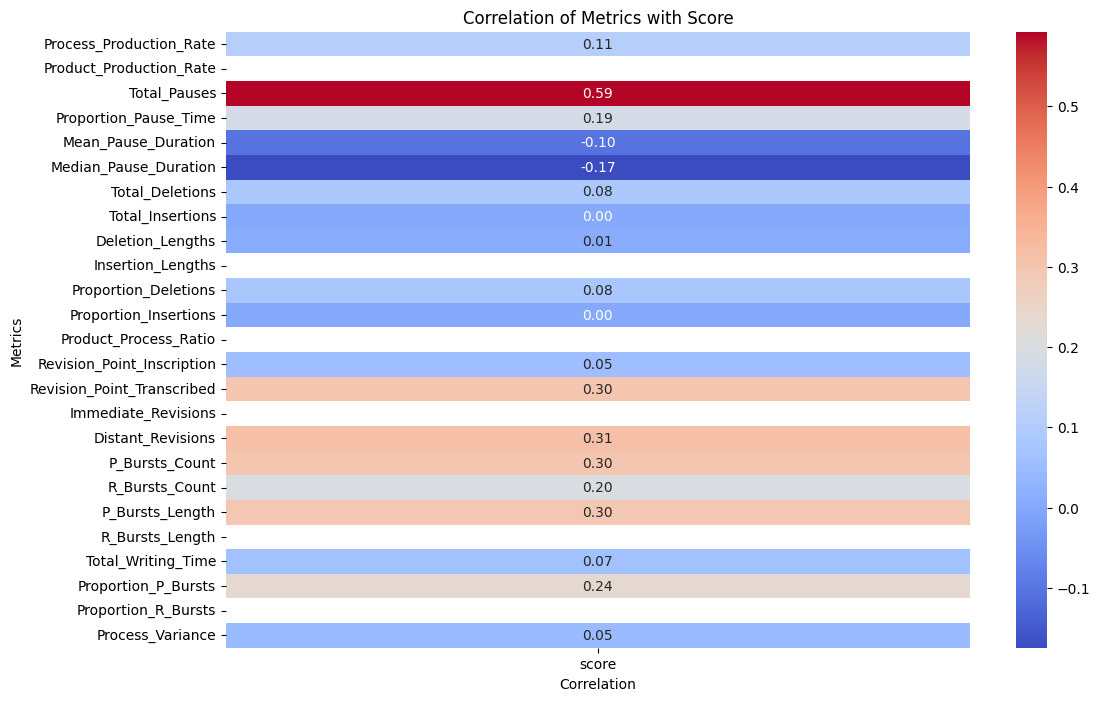

In [9]:
# Drop the 'id' column
combined_metrics_without_id = combined_metrics.drop(columns=['id'])

# Calculate the correlation matrix
correlation_matrix = combined_metrics_without_id.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix['score'].drop('score').to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation of Metrics with Score')
plt.xlabel('Correlation')
plt.ylabel('Metrics')
plt.show()


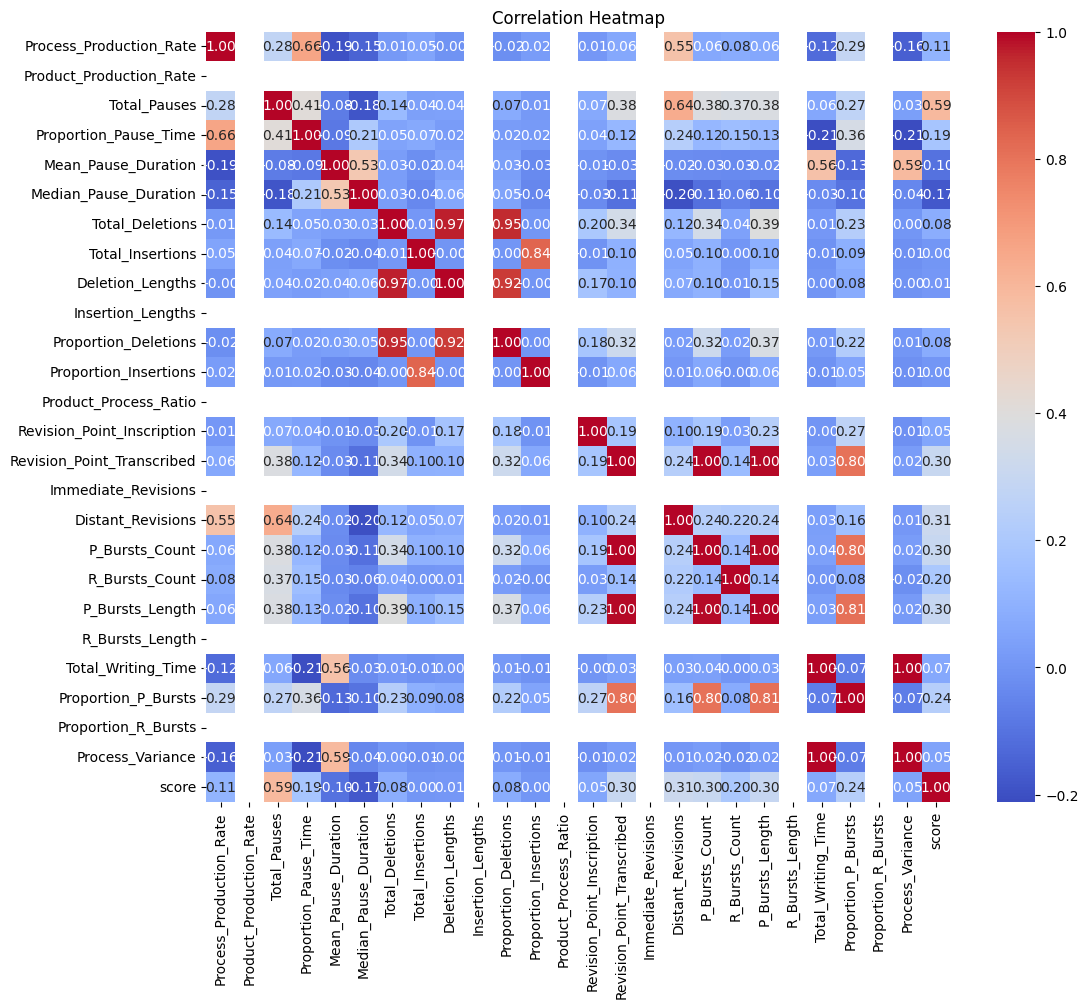

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the 'id' column if it's present
combined_metrics_1 = combined_metrics.drop(columns=['id'], errors='ignore')

# Calculate the correlation matrix
correlation_matrix = combined_metrics_1.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Heatmap')
plt.show()

Epoch 1/60
62/62 [==============================] - 3s 6ms/step - loss: 11.7403 - mae: 3.2415 - val_loss: 5.9203 - val_mae: 2.2762
Epoch 2/60
62/62 [==============================] - 0s 3ms/step - loss: 2.4609 - mae: 1.2591 - val_loss: 0.7854 - val_mae: 0.7051
Epoch 3/60
62/62 [==============================] - 0s 3ms/step - loss: 1.6195 - mae: 0.9993 - val_loss: 0.7728 - val_mae: 0.7023
Epoch 4/60
62/62 [==============================] - 0s 3ms/step - loss: 1.5440 - mae: 0.9890 - val_loss: 0.6990 - val_mae: 0.6557
Epoch 5/60
62/62 [==============================] - 0s 3ms/step - loss: 1.4737 - mae: 0.9610 - val_loss: 0.7062 - val_mae: 0.6637
Epoch 6/60
62/62 [==============================] - 0s 3ms/step - loss: 1.4912 - mae: 0.9568 - val_loss: 0.6852 - val_mae: 0.6512
Epoch 7/60
62/62 [==============================] - 0s 3ms/step - loss: 1.4237 - mae: 0.9499 - val_loss: 0.6825 - val_mae: 0.6526
Epoch 8/60
62/62 [==============================] - 0s 3ms/step - loss: 1.3931 - mae: 0.9

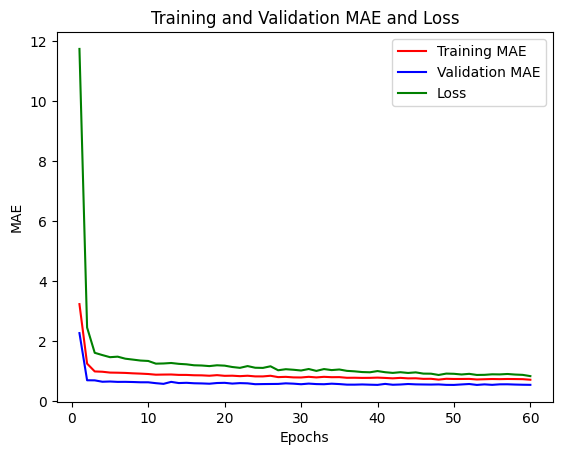

In [11]:
dataset = combined_metrics.fillna(0)
X = dataset.drop(columns=['id','score','Product_Production_Rate'])
y = dataset['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

# Remove infinite and very large values
X_train = np.nan_to_num(X_train, nan=0, posinf=0, neginf=0)
X_test = np.nan_to_num(X_test, nan=0, posinf=0, neginf=0)

# Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)



model = Sequential([
    Dense(64, activation='relu'
          , input_shape=(X_train_normalized.shape[1],)),  
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.001)
              , loss='mean_squared_error'
              , metrics=['mae'])

history = model.fit(X_train_normalized
                    , y_train
                    , epochs=60
                    , batch_size=32
                    , verbose=1
                    , validation_data=(X_test_normalized, y_test))

# Get MAE values from the history object
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']

# Plot MAE over epochs
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'r', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.plot(epochs, loss, 'g', label='Loss')
plt.title('Training and Validation MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [12]:
loss, mae = model.evaluate(X_test_normalized, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}, Test MAE: {mae:.4f}')

Test Loss: 0.5081, Test MAE: 0.5528


In [13]:
test_production_rate_metrics = calculate_production_rate(df_test_logs)
test_pause_metrics = calculate_pause_metrics(df_test_logs)
test_revision_metrics = calculate_revision_metrics(df_test_logs)
test_burst_metrics = calculate_burst_metrics(df_test_logs)
test_process_variance_metrics = calculate_process_variance(df_test_logs)

test_metrics_dfs = [
    test_production_rate_metrics,
    test_pause_metrics,
    test_revision_metrics,
    test_burst_metrics,
    test_process_variance_metrics
]
test_combined_metrics = reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), test_metrics_dfs)

In [14]:
ids = test_combined_metrics['id']
X_test_new = test_combined_metrics.drop(columns=['id','Product_Production_Rate'])
X_test_new = np.nan_to_num(X_test_new, nan=0, posinf=0, neginf=0)
X_new_processed = scaler.transform(X_test_new)  # Assuming you've normalized the new data
print(X_new_processed.shape[1])

# Make predictions on the preprocessed new data
predictions = model.predict(X_new_processed)

# Merge the IDs back with the predictions
submission = pd.DataFrame({'id': ids, 'score': predictions.flatten()})

# Now predicted_data contains the IDs merged with their respective predictions


24
1/1 [==============================] - 0s 93ms/step


In [15]:
submission.to_csv("submission.csv", index=False)